<a href="https://colab.research.google.com/github/Ateeth/Prediction-of-Stroke-from-Healthcare-Dataset/blob/main/Predictive_Analytics_Review2Part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings 
warnings.filterwarnings('ignore')

# basic libraries
import os
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
import time

#visulaization modules

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode

plt.rc('figure',figsize=(17,13))
sns.set_context('paper',font_scale=2)

init_notebook_mode(connected= True)

#Common model helpers
from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   OneHotEncoder)
from sklearn import metrics
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

**Import the Dataset**

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Ateeth/Prediction-of-Stroke-from-Healthcare-Dataset/main/healthcare-dataset-stroke-data.csv', delimiter = ',', encoding = 'utf-8')
df.head(3).T

,0,1,2
id,9046,51676,31112
gender,Male,Female,Male
age,67.0,61.0,80.0
hypertension,0,0,0
heart_disease,1,0,1
ever_married,Yes,Yes,Yes
work_type,Private,Self-employed,Private
Residence_type,Urban,Rural,Rural
avg_glucose_level,228.69,202.21,105.92
bmi,36.6,NaN,32.5


**Missing-Value Analysis**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In our dataset, we have both numerical and categorical variables.

It is essential to see whether columns are correctly inferred.

The most important one to look for is our target variable 'stroke'

'Stroke' is detected as an integer, not as an object.

Target variable is coded as 1 for positive cases (has a stroke) and 0 for negative cases (does not have a stroke)

Both 'Hypertension' and 'heart disease" are detected as an integer, not as an object.

We have 3 categorical variables, which we have to encode as numerical

**Statistics of numerical and categorical data**

In [4]:
# stats of numerical data
round (df.describe(exclude = 'object'), 2)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.00,5110.0,5110.00,5110.00,4909.00,5110.00
mean,36517.83,43.23,0.1,0.05,106.15,28.89,0.05
std,21161.72,22.61,0.3,0.23,45.28,7.85,0.22
min,67.00,0.08,0.0,0.00,55.12,10.30,0.00
25%,17741.25,25.00,0.0,0.00,77.24,23.50,0.00
50%,36932.00,45.00,0.0,0.00,91.88,28.10,0.00
75%,54682.00,61.00,0.0,0.00,114.09,33.10,0.00
max,72940.00,82.00,1.0,1.00,271.74,97.60,1.00


In [5]:
# stats of categorical data
df.describe(exclude = ['float', 'int64'])

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


*Initial Insights About Dataset*
Data from bmi feature is missing.

Both Categorical and numerical features are present.

Categorical Features: gender, ever_married, work_type, Residence_type, smoking_status

Binary Numerical Features: hypertension,heart_disease, stroke

Continous Numerical Features: age, avg_glucose_level, bmi

Most of the data is categorical which need a special attention to visulaize those variables


**Visualizing Missing Values**

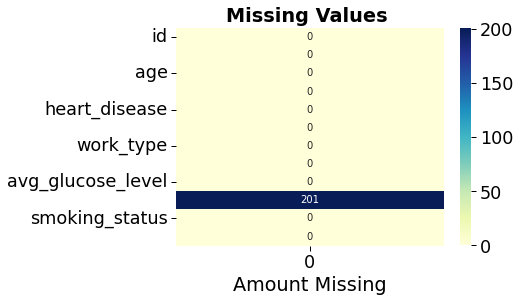

In [6]:
plt.title('Missing Values ',fontweight='bold')
ax=sns.heatmap(df.isna().sum().to_frame(),annot=True,fmt='d',cmap='YlGnBu',cbar=True)
ax.set_xlabel('Amount Missing')
plt.show()

**Explorartory Data Analysis**

In [7]:
categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married',
'work_type', 'Residence_type', 'smoking_status']

numerical = ['age','avg_glucose_level', 'bmi']

In [8]:
df[numerical].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


**Analysis of Entire Sample Space**

In [9]:
fig=px.pie(df,names='stroke', color_discrete_sequence=['#46205c', '#b74068']) 
fig.update_layout(title='<b>Proportion of Stroke Samples<b> ')
fig.show(renderer="colab") 

We are clearly dealing with an imbalanced dataset, and later in our pipeline, we will have to deal with this problem potentially with upscaling; that way, we give our models a better chance of learning the small details which define potential stroke individuals.

In [10]:
fig = make_subplots(
    rows=2, cols=2,subplot_titles=('','<b>Distribution Of Female Ages<b>','<b>Distribution Of Male Ages<b>'),
    vertical_spacing=0.09,
    specs=[[{"type": "pie","rowspan": 2},{"type": "histogram"}] ,[None,{"type": "histogram"}],]
)

fig.add_trace(
    go.Pie(values=df.gender.value_counts().values,labels=['<b>Female<b>','<b>Male<b>','<b>Other<b>'],hole=0.3,pull=[0,0.08,0.3],marker_colors=['burlywood','darkblue','green'],textposition='inside'),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(
        x=df.query('gender=="Female"').age,marker= dict(color='burlywood'),name='Female Ages'
    ),
    row=1, col=2
)


fig.add_trace(
    go.Histogram(
        x=df.query('gender=="Male"').age,marker= dict(color='darkblue'),name='Male Ages'
    ),
    row=2, col=2
)


fig.update_layout(
    height=800,
    showlegend=True,
    title_text="<b>Age-Sex Inference<b>",
)

fig.show(renderer="colab")

There are slightly more females in our sample data than males and from a visual perspective, the ages seem to be normally distributed but with a high variance measure due to the visible fat tail.

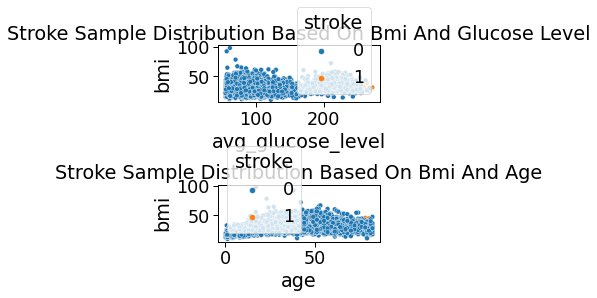

In [11]:
plt.subplot(2,1,1)
plt.title('Stroke Sample Distribution Based On Bmi And Glucose Level')
sns.scatterplot(x=df['avg_glucose_level'],y=df['bmi'],hue=df['stroke'])
plt.subplot(2,1,2)
plt.title('Stroke Sample Distribution Based On Bmi And Age')
sns.scatterplot(x=df['age'],y=df['bmi'],hue=df['stroke'])
plt.tight_layout()
plt.show()

**It seems that we have two underlying populations based on the first scatter plot where the x-axis is the glucose level.
What it visible straight away is the fact the in both scatterplots the individuals who had a stroke are located in the BMI value region under 60 and in high glucose levels as well as old age.**

**Analysis of Stroke Positive Population**

*a. According to Gender*

In [12]:
stroke_population = df.query('stroke ==1').copy()

fig = make_subplots(
    rows=2, cols=2,subplot_titles=('','<b>Distribution Of Female Ages<b>','<b>Distribution Of Male Ages<b>'), vertical_spacing=0.09,
    specs=[[{"type": "pie","rowspan": 2},{"type": "histogram"}] , [None ,{"type": "histogram"}] ,]
)

fig.add_trace(
    go.Pie(values=stroke_population.gender.value_counts().values,labels=['<b>Female<b>','<b>Male<b>','<b>Other<b>'],hole=0.3,pull=[0,0.08,0.3],marker_colors=['burlywood','darkblue','green'],textposition='inside'),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(
        x=stroke_population.query('gender=="Female"').age,marker= dict(color='burlywood'),name='Female Ages'
    ),
    row=1, col=2
)


fig.add_trace(
    go.Histogram(
        x=stroke_population.query('gender=="Male"').age,marker= dict(color='darkblue'),name='Male Ages'
    ),
    row=2, col=2
)


fig.update_layout(
    height=800,
    showlegend=True,
    title_text="<b>Age-Sex Infrence Of Stroke Positive Samples<b>",
)

fig.show(renderer="colab")

When looking at the inner distribution of our different attributes among stroke positive samples

i)Females, although appearing more than males in our dataset, also surpass the males in the stroke sample space

ii)Males are more prone to strokes in their early 50/60 where the median of the women stroke age is around 75-79.

b. According to Work Type

c. According to Residence Type

d. According to Marriage

In [13]:
stroke_population = df.query('stroke ==1').copy()

fig = make_subplots(
    rows=2, cols=2,subplot_titles=('<b>Proportion Of Different Work Types<b>','<b>Proportion Of Married Individuals<b>','<b>Proportion Of Residence Type<b>','Residuals'),
    vertical_spacing=0.09,
    specs=[[{"type": "pie","rowspan": 2}       ,{"type": "pie"}] ,
           [None                               ,{"type": "pie"}]            ,                                      
          ]
)

fig.add_trace(
    go.Pie(values=stroke_population.work_type.value_counts().values,labels=['<b>Private<b>','<b>Self-employed<b>','<b>Govt_job<b>','<b>children<b>','<b>Never_worked<b>'],hole=0.3,pull=[0,0.08,0.03,0.2],marker_colors=['red','lightgreen','darkblue','black','yellow'],textposition='inside'),
    row=1, col=1
)

fig.add_trace(
    go.Pie(values=stroke_population.ever_married.value_counts().values,labels=['<b>Yes<b>','<b>No<b>'],hole=0.3,pull=[0,0.08],marker_colors=['burlywood','darkblue'],textposition='inside'),
    row=1, col=2
)
fig.add_trace(
    go.Pie(values=stroke_population.Residence_type.value_counts().values,labels=['<b>Urban<b>','<b>Rural<b>'],hole=0.3,pull=[0,0.08],marker_colors=['black','green'],textposition='inside'),
    row=2, col=2
)

fig.update_layout(
    height=800,
    showlegend=True,
    title_text="<b>Different Categorical Attributes Of Stroke Samples<b>",
)

fig.show(renderer = "colab")

It seems that the marriage status and the residence type are distributed in a way that doesn't tell us anything confounding about stroke-positive individuals

The residence type is close to a uniform distribution and the marriage status is almost completely dominated by one of the values.

*e. According to Smoking category*

In [14]:
fig = px.pie(stroke_population,names='smoking_status')
fig.update_layout(title='<b>Proportion Of Different Smoking Categories Among Stroke Population<b>')
fig.show(renderer = "colab")

**Correlation**

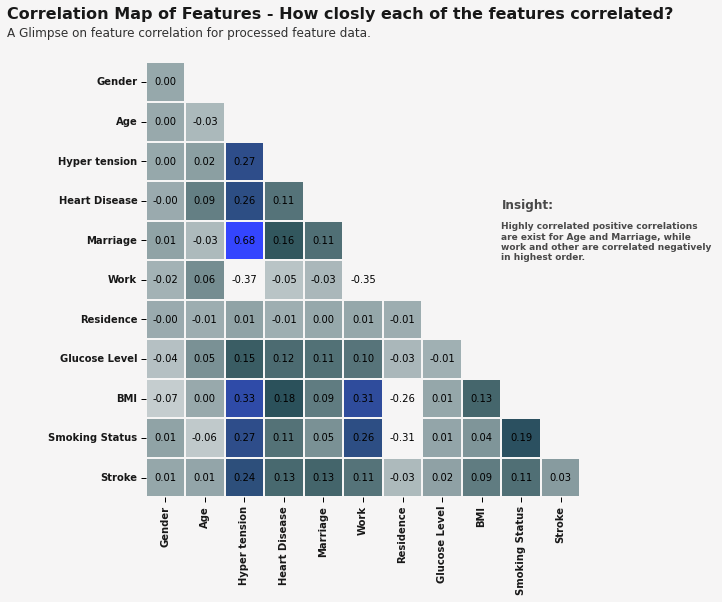

In [15]:
#visualize the correlation
df_copy = df.copy()

# feature log transformations 
df_copy['age'] = df_copy['age'].apply(lambda x: np.log(x+10)*3)
df_copy['avg_glucose_level'] = df_copy['avg_glucose_level'].apply(lambda x: np.log(x+10)*2)
df_copy['bmi'] = df_copy['bmi'].apply(lambda x: np.log(x+10)*2)


# preprocessing - label encoding and numerical value scaling
ohe = OneHotEncoder()
ss = StandardScaler() # z-transform
le = LabelEncoder()

## label encoding of ordinal categorical features
for col in df_copy.columns:
    df_copy[col] = le.fit_transform(df_copy[col])
    
cols = df_copy.columns
## normalizing with standard scaler of numerical features
df_copy[cols] = ss.fit_transform(df_copy[cols])


# correlation map for all the features
df_corr = df_copy.corr()
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

fig, ax = plt.subplots(figsize = (8,8))
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()


colors=['#f6f5f5','#2b5158','#3445fe']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",cmap = colormap,
           vmin=-0.15, vmax=0.5, cbar_kws={"shrink": .5, }, ax = ax, cbar = False,
           linewidth = 1,linecolor = '#f6f5f5', square = True,annot_kws = {'size':10, 'color':'black'} )
# yticks
ax.tick_params(axis = 'y', rotation=0)
xticks = ['Gender', 'Age','Hyper tension', 'Heart Disease', 'Marriage', 'Work', 'Residence', 'Glucose Level', 'BMI', 'Smoking Status','Stroke','BMI Cat','Age Cat']
yticks = ['Gender', 'Age','Hyper tension', 'Heart Disease', 'Marriage', 'Work', 'Residence', 'Glucose Level', 'BMI', 'Smoking Status','Stroke','BMI Cat','Age Cat']
ax.set_xticklabels(xticks, { 'size':10, 'weight':'bold'},rotation = 90, alpha = 0.9)
ax.set_yticklabels(yticks, { 'size':10, 'weight':'bold'}, rotation = 0, alpha = 0.9)
ax.text(-3.5,-1.1, 'Correlation Map of Features - How closly each of the features correlated?',{ 'size': 16, 'weight':'bold'}, alpha = 0.9)
ax.text(-3.5,-0.65, 'A Glimpse on feature correlation for processed feature data.',{ 'size': 12, 'weight':'normal'}, alpha = 0.8)

ax.text(9,5, 'Highly correlated positive correlations \nare exist for Age and Marriage, while \nwork and other are correlated negatively \nin highest order.',{ 'size': 9, 'weight':'bold'},alpha = 0.7)
ax.text(9,3.7, 'Insight:',{ 'size': 12, 'weight':'bold'},alpha = 0.7)


fig.show()

Distribution of BMI

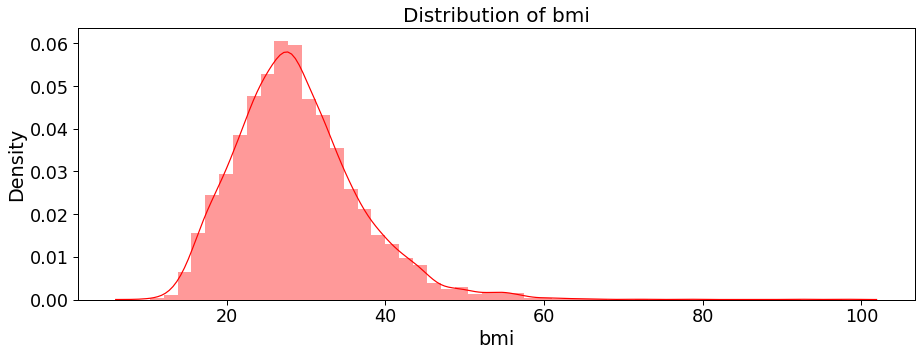

In [16]:
plt.subplots(figsize=(15,5))
sns.distplot(df['bmi'], color = 'r')
plt.title('Distribution of bmi', fontsize = 20)
plt.show()

Distribution of Average Glucose level

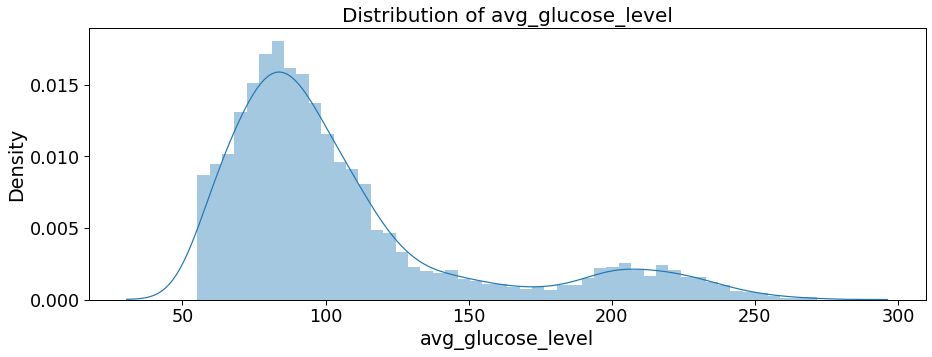

In [17]:
plt.subplots(figsize=(15,5))
sns.distplot(df['avg_glucose_level'])
plt.title('Distribution of avg_glucose_level', fontsize = 20)
plt.show()

Distribution of Age

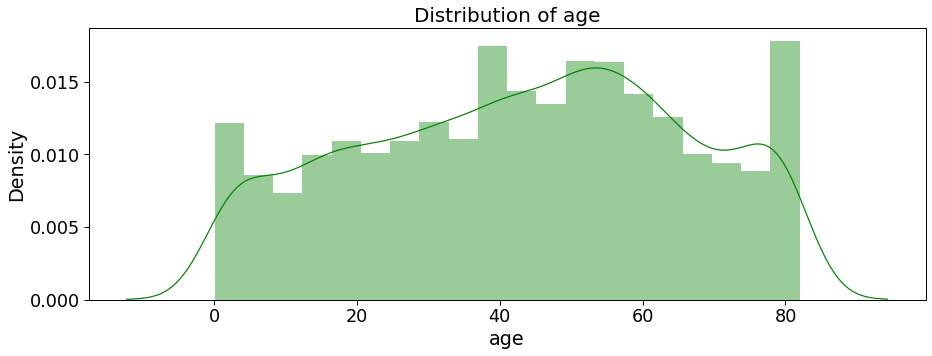

In [18]:
plt.subplots(figsize=(15,5))
sns.distplot(df['age'],color='g')
plt.title('Distribution of age', fontsize = 20)
plt.show()

In [19]:
df[numerical].skew()

age                 -0.137059
avg_glucose_level    1.572284
bmi                  1.055340
dtype: float64

Based on the result, age has slight left skew, other two features have right tail, positively skewed shape distribution.

 HANDLING MISSING VALUES USING KNN IMPUTATION
 
 Default neighbours n=5





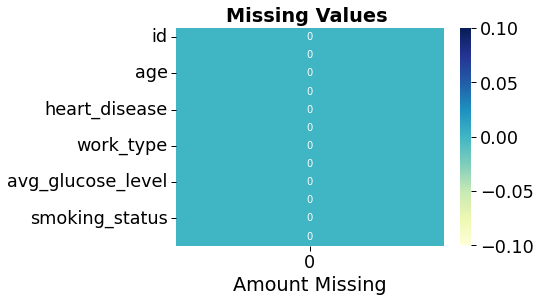

In [20]:
from sklearn.impute import KNNImputer
imputer = KNNImputer()
df_filled = imputer.fit_transform(df[numerical]);
df4=pd.DataFrame(df_filled , columns = ['age','avg_glucose_level', 'bmi'])
df['bmi'] = df4['bmi']
plt.title('Missing Values ',fontweight='bold')
ax=sns.heatmap(df.isna().sum().to_frame(),annot=True,fmt='d',cmap='YlGnBu',cbar=True)
ax.set_xlabel('Amount Missing')
plt.show()

CHECK FOR OUTLIERS IN OUR DATA

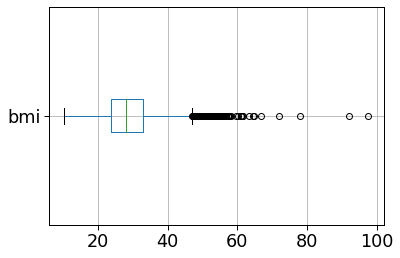

In [21]:
#BMI FEATURE:
df.boxplot(column='bmi',vert=False)

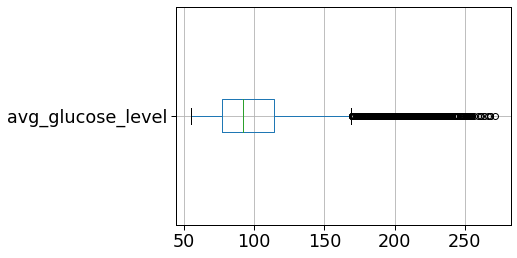

In [22]:
#AVG_GLUCOSE_LEVEL:
df.boxplot(column='avg_glucose_level',vert=False)

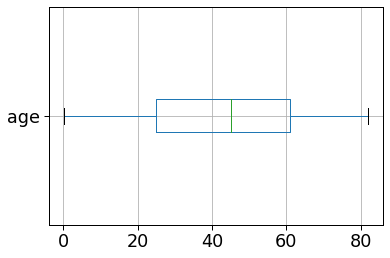

In [23]:
#Age:
df.boxplot(column='age',vert=False)

HANDLE THE CATEGORICAL VARIABLES USING LABEL ENCODER

In [24]:
from sklearn.preprocessing import LabelEncoder
enc=LabelEncoder()

In [25]:
gender=enc.fit_transform(df['gender'])
smoking_status=enc.fit_transform(df['smoking_status'])
work_type=enc.fit_transform(df['work_type'])
Residence_type=enc.fit_transform(df['Residence_type'])
ever_married=enc.fit_transform(df['ever_married'])

In [26]:
df['ever_married']=ever_married
df['Residence_type']=Residence_type
df['smoking_status']=smoking_status
df['gender']=gender
df['work_type']=work_type

In [27]:
df[['ever_married', 'Residence_type', 'smoking_status', 'gender', 'work_type']].head()

,ever_married,Residence_type,smoking_status,gender,work_type
0,1,1,1,1,2
1,1,0,2,0,3
2,1,0,2,1,2
3,1,1,3,0,2
4,1,0,2,0,3


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   int64  
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   int64  
 6   work_type          5110 non-null   int64  
 7   Residence_type     5110 non-null   int64  
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   int64  
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 479.2 KB


THE CATEGORICAL FEATURES ARE HANDLED

REVOME UNNECESSARY COLUMNS 


In [29]:
#ID COLUMN IS NOT REQUIRED.
df = df.drop('id', axis=1)

In [30]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.60,1,1
1,0,61.0,0,0,1,3,0,202.21,31.38,2,1
2,1,80.0,0,1,1,2,0,105.92,32.50,2,1
3,0,49.0,0,0,1,2,1,171.23,34.40,3,1
4,0,79.0,1,0,1,3,0,174.12,24.00,2,1


SPLIT DATA INTO X AND Y 

Y will hold the target variable

In [31]:
X = df.drop('stroke', axis=1)
y = df['stroke']

Split into Train and Test Models

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (3577, 10)
Number transactions y_train dataset:  (3577,)
Number transactions X_test dataset:  (1533, 10)
Number transactions y_test dataset:  (1533,)


HANDLING IMBALANCED DATA

WE WILL BE USING SMOTE TECHNIQUE TO HANDLE THE IMBALANCED DATA

In [33]:
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
#ravel() used to flatten
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 173
Before OverSampling, counts of label '0': 3404 

After OverSampling, the shape of train_X: (6808, 10)
After OverSampling, the shape of train_y: (6808,) 

After OverSampling, counts of label '1': 3404
After OverSampling, counts of label '0': 3404


THE DATA IS NOW BALANCED

In [34]:
df2=pd.DataFrame(y_train_res,columns=['stroke'])
fig=px.pie(df2,names='stroke',color_discrete_sequence=['#46205c', '#b74068']) 
fig.update_layout(title='<b>Proportion of Stroke Samples<b> ')
fig.show(renderer="colab") 

**BASELINE MODEL**

In [35]:
!pip install dabl
import dabl
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
accuracies = {}

     |████████████████████████████████| 558 kB 4.5 MB/s 


In [36]:

sc = dabl.SimpleClassifier().fit(X_train_res, y_train_res)
print("Accuracy score", sc.score(X_test, y_test))
acc=sc.score(X_test, y_test)*100
accuracies['Base Model']=acc
print("Test Accuracy of Base Model: {:.2f}%".format(acc))

Running DummyClassifier()
accuracy: 0.500 average_precision: 0.500 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.333
=== new best DummyClassifier() (using recall_macro):
accuracy: 0.500 average_precision: 0.500 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.333

Running GaussianNB()
accuracy: 0.656 average_precision: 0.839 roc_auc: 0.872 recall_macro: 0.656 f1_macro: 0.611
=== new best GaussianNB() (using recall_macro):
accuracy: 0.656 average_precision: 0.839 roc_auc: 0.872 recall_macro: 0.656 f1_macro: 0.611

Running MultinomialNB()
accuracy: 0.724 average_precision: 0.810 roc_auc: 0.809 recall_macro: 0.724 f1_macro: 0.723
=== new best MultinomialNB() (using recall_macro):
accuracy: 0.724 average_precision: 0.810 roc_auc: 0.809 recall_macro: 0.724 f1_macro: 0.723

Running DecisionTreeClassifier(class_weight='balanced', max_depth=1)
accuracy: 0.784 average_precision: 0.706 roc_auc: 0.784 recall_macro: 0.784 f1_macro: 0.780
=== new best DecisionTreeClassifier(class_weight='balanced', 

**Naive Bayes**

In [37]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_res, y_train_res)

GaussianNB()

In [38]:
print("Naive Bayes score: ",nb.score(X_test, y_test))
acc=nb.score(X_test, y_test)*100;
accuracies['Naive Bayes']=acc
print("Test Accuracy of Naive Bayes Algorithm: {:.2f}%".format(acc))

Naive Bayes score:  0.735812133072407
Test Accuracy of Naive Bayes Algorithm: 73.58%


**Logistic Regression**

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_res, y_train_res)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
cm = confusion_matrix(y_test, predictions)
print("Confusion matrix ")
print(cm)
acc=score*100
accuracies['Logistic Regression']=acc
print("Test Accuracy of Logistic Regression Algorithm: {:.2f}%".format(acc))

Confusion matrix 
[[1139  318]
 [  32   44]]
Test Accuracy of Logistic Regression Algorithm: 77.17%


**SVM**

In [40]:
from sklearn.svm import SVC

svm = SVC(random_state = 1)
svm.fit(X_train_res, y_train_res)

acc = svm.score(X_test,y_test)*100
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.2f}%".format(acc))

Test Accuracy of SVM Algorithm: 70.45%


**KNN**

In [41]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_res1 = sc.fit_transform(X_train_res)
X_test1 = sc.transform(X_test)
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train_res1, y_train_res)

y_pred = classifier.predict(X_test1)
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix")
print(cm)
ac = accuracy_score(y_test,y_pred)
ac
acc=ac*100
accuracies['KNN'] = acc
print("Test Accuracy of KNN Algorithm: {:.2f}%".format(acc))

Confusion matrix
[[1211  246]
 [  47   29]]
Test Accuracy of KNN Algorithm: 80.89%


**Decision Tree**

In [43]:
from sklearn.tree import DecisionTreeClassifier

# Function to perform training with giniIndex.
def train_using_gini(X_train, X_test, y_train):
  
    # Creating the classifier object
    clf_gini = DecisionTreeClassifier(criterion = "gini",
            random_state = 100,max_depth=3, min_samples_leaf=5)
  
    # Performing training
    clf_gini.fit(X_train, y_train)
    return clf_gini
      
# Function to perform training with entropy.
def train_using_entropy(X_train, X_test, y_train):
  
    # Decision tree with entropy
    clf_entropy = DecisionTreeClassifier(
            criterion = "entropy", random_state = 100,
            max_depth = 3, min_samples_leaf = 5)
  
    # Performing training
    clf_entropy.fit(X_train, y_train)
    return clf_entropy
  
  
# Function to make predictions
def prediction(X_test, clf_object):
  
    # Predicton on test with giniIndex
    y_pred = clf_object.predict(X_test)
    print("Predicted values:")
    print(y_pred)
    return y_pred

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Function to calculate accuracy
def cal_accuracy(y_test, y_pred):
      
    print("Confusion Matrix: \n",
        confusion_matrix(y_test, y_pred))
      
    print ("Accuracy : ",
    accuracy_score(y_test,y_pred)*100)
      
    print("Report : ",
    classification_report(y_test, y_pred))

    return accuracy_score(y_test,y_pred)*100

In [45]:
clf_gini = train_using_gini(X_train_res, X_test, y_train_res)
clf_entropy = train_using_entropy(X_train_res, X_test, y_train_res)
 
# Operational Phase
print("Results Using Gini Index:")
  
# Prediction using gini
y_pred_gini = prediction(X_test, clf_gini)

giniAcc = cal_accuracy(y_test, y_pred_gini)
accuracies['DT by gini']=giniAcc
print(giniAcc)

Results Using Gini Index:
Predicted values:
[1 0 1 ... 0 1 0]
Confusion Matrix: 
 [[979 478]
 [ 16  60]]
Accuracy :  67.77560339204175
Report :                precision    recall  f1-score   support

           0       0.98      0.67      0.80      1457
           1       0.11      0.79      0.20        76

    accuracy                           0.68      1533
   macro avg       0.55      0.73      0.50      1533
weighted avg       0.94      0.68      0.77      1533

67.77560339204175


In [46]:
print("Results Using Entropy:")
# Prediction using entropy
y_pred_entropy = prediction(X_test, clf_entropy)


entAcc = cal_accuracy(y_test, y_pred_entropy)
accuracies['DT by entropy']=entAcc
print(entAcc)

Results Using Entropy:
Predicted values:
[1 0 1 ... 0 1 0]
Confusion Matrix: 
 [[983 474]
 [ 16  60]]
Accuracy :  68.0365296803653
Report :                precision    recall  f1-score   support

           0       0.98      0.67      0.80      1457
           1       0.11      0.79      0.20        76

    accuracy                           0.68      1533
   macro avg       0.55      0.73      0.50      1533
weighted avg       0.94      0.68      0.77      1533

68.0365296803653


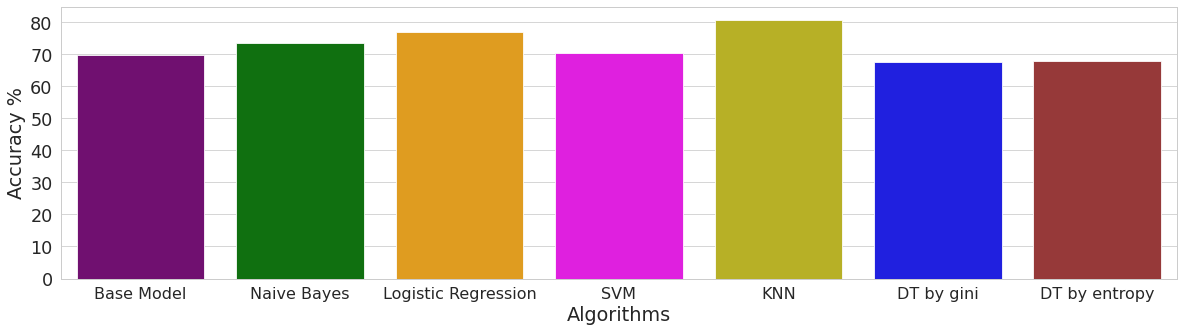

In [47]:

colors = ["purple", "green", "orange", "magenta","#CFC60E",'blue','brown']

sns.set_style("whitegrid")
plt.figure(figsize=(20,5))
plt.yticks(np.arange(0,100,10))
plt.xticks(fontsize= 16)
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()